Problem Statement- Given stock, income_statement, balance sheet, and cash flow data, we are looking to predict a company’s future earnings, or monthly performance based on given features

## Imports

In [92]:

#Import SKLearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

#Import audio and plotting libraries
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import wave
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#Set Default plot size
plt.rcParams['figure.figsize'] = (12, 8)



## Functions

In [107]:
def waveplot(file1, file2, title1, title2):
    '''This function creates a waveplot that shows the time and signal of each 
    data sample. Code adapted from Librosa documentation'''
    
    #Set Fig Size and load file
    fig, ax = plt.subplots(nrows=2, sharex=True)
    
    #Load waveform
    y, sr = librosa.load(file1)
    y_harm, y_perc = librosa.effects.hpss(y)
    librosa.display.waveshow(y_harm, sr=sr, ax = ax[0], alpha=0.5,  label='Harmonic')
    librosa.display.waveshow(y_perc, sr=sr, color='r', ax = ax[0], alpha=0.5,  label='Percussive')
    ax[0].set(title=title1)
    ax[0].label_outer()
    ax[0].legend()
    
    y, sr = librosa.load(file2)
    y_harm, y_perc = librosa.effects.hpss(y)
    librosa.display.waveshow(y_harm, sr=sr, ax = ax[1], alpha=0.5,  label='Harmonic')
    librosa.display.waveshow(y_perc, sr=sr, color='r', ax = ax[1], alpha=0.5,  label='Percussive')
    ax[1].set(title=title2)
    ax[1].label_outer()
    ax[1].legend()




## EDA

In [78]:
File_Sample = 'Data/Ravdess_Audio_Data/Actor_01/03-01-01-01-02-02-01.wav'


**Here is what each number in the file segment "03-01-01-01-02-02-01" refers to:**

- Elements
    - **1st:  Modality** (03 = audio-only)
    - **2nd:  Vocal channel** (01 = speech)
    - **3rd:  Emotion** (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
    - **4th:  Emotional intensity** (01 = normal, 02 = strong). 
        - Note: There is no strong intensity for the 'neutral' emotion
    - **5th:  Statement** (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door")
    - 6th:  Repetition (01 = 1st repetition, 02 = 2nd repetition)
    - 7th:  Actor (01 to 24)
        - Odd numbered actors are male, even numbered actors are female


In [38]:
#Plays an audio file 

#Audio Text: "Dogs are sitting by the door"

from pydub import AudioSegment
from pydub.playback import play

sample = AudioSegment.from_wav('Data/Ravdess_Audio_Data/Actor_01/03-01-01-01-02-02-01.wav')

play(sample)

Our files are fairly short snippets, usually lasting a second or two long, where each actor changes tone, pitch, and inflection to carry a certain emotion. In the case below, the actor is displaying a neutral emotion with normal intensity, while the second file sample shows the same actor with an angry emotion 

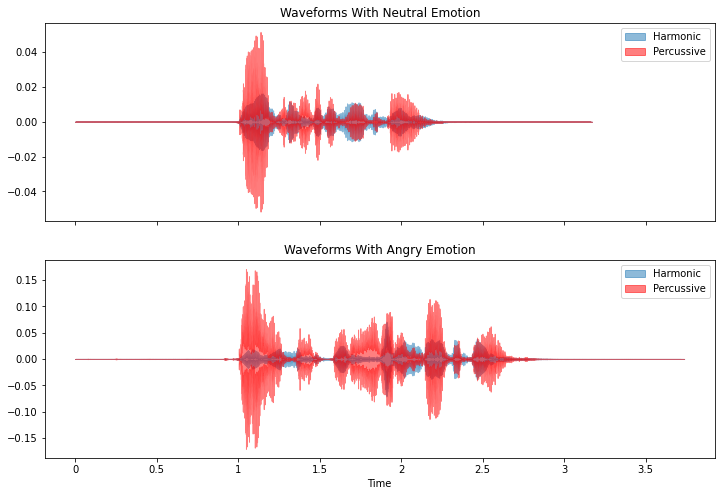

In [108]:
title2 = 'Data/Ravdess_Audio_Data/Actor_01/03-01-05-01-02-02-01.wav'

waveplot(File_Sample, title2, 'Waveforms With Neutral Emotion', 'Waveforms With Angry Emotion')

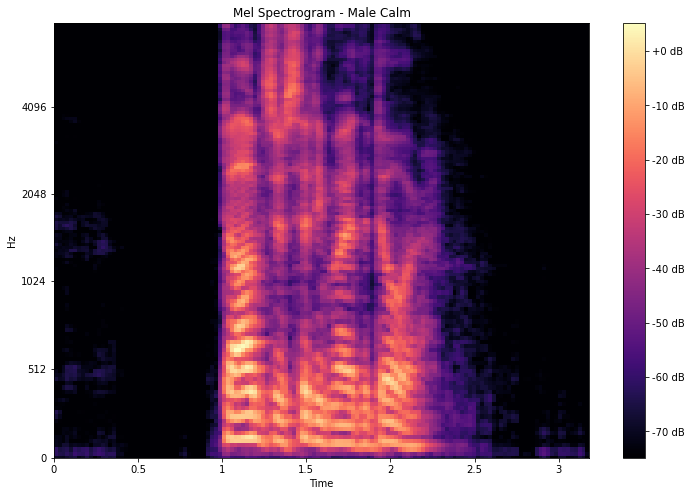

In [111]:
# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Calm')
plt.savefig('MelSpec_MaleCalm.png')
plt.colorbar(format='%+2.0f dB');

## Null Model

Given we have 8 emotions we are choosing from, the probability of correctly guessing one, without replacement, is about 13%. 
This will be our null score we will look to improve our model off of

## Audio Extraction

As we are looking to build a model for audio classification, we look extract several audio features. Our baseline will only use MFCC, While we will use MEL and Chroma later on to improve on our model's accuracy.

- **MFCC (Mel-Frequency Cepstral Coefficients):** 
    - MFCC, features represent phonemes (distinct units of sound) coming off of the vocal tract
- **MEL** 
    - THE MEL scale is a scale that relates the perceived frequency of a tone to the actual measured frequency. If we were to look at, say, a land-line dial up, the mel scale would measure the distance between these sounds.
    
- **Chroma**
    - The chroma
    is a powerful measurement of pitch, differentiating between 12 classes of pitch

In [ ]:
path = "./Data/Ravdess_Audio_Data"
files = glob.glob(path + '/*.wav')

# create empty list to store dataframes
list_ = []

# loop through list of files and read each one into a dataframe and append to list
for f in files:
    # read in csv
    temp_df = pd.read_csv(f)
    # append df to list
    li.append(temp_df)
    print(f'Successfully created dataframe for {f} with shape {temp_df.shape}')

# concatenate our list of dataframes into one!
df = pd.concat(li, axis=0)
print(df.shape)
df.head()

In [121]:


directory=glob.glob("./Data/Ravdess_Audio_Data/*")
directory.sort()

dir_list

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [122]:
emotion = []
gender = []
path = []

for i in dir_list:
    location = os.listdir(dir_list + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(dir_list + i + '/' + f)

        


TypeError: can only concatenate list (not "str") to list

In [ ]:
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

## Base Model